# **Stadium Attendance Prediction**

### Project Overview

This notebook builds a machine learning model to predict **stadium attendance** (as a percentage of capacity) for matches in the Belgian Jupiler Pro League.

**Central question**: Does weather data improve attendance predictions, or are structural factors (stadium size, team quality, timing) sufficient?

**Dataset**: ~944 matches from the Jupiler Pro League (2019–2022 seasons), with features covering:
- Match context (teams, rankings, matchday, time slot)
- Stadium characteristics (capacity, location, roof coverage)
- Weather conditions (temperature, precipitation type, good/bad classification)
- Macroeconomic indicators (GDP, CPI, employment rate — lagged)

**Target variable**: `PercentageAttendance` — the ratio of actual attendance to stadium capacity, bounded between 0 and 1.

**Hypothesis**: While weather intuitively affects the decision to attend an outdoor event, we expect its predictive power to be limited because:
1. Most tickets are purchased before weather forecasts are reliable
2. Belgian weather rarely reaches extremes that would deter committed fans
3. Season ticket holders attend regardless of conditions

## **Data Processing**

In [2]:
!pip install seaborn

In [3]:
#Import necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import pickle
import shap
import sqlite3

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# we'll need this further to locate football.db
path  = "../Data/"

In [5]:
import sqlite3
import pandas as pd

db_path = path + "football.db"

conn = sqlite3.connect(db_path)

query = """
SELECT
    -- Competition was constant in the original CSV
    'Jupiler Pro League'                    AS Competition,

    -- calendar / ids
    m.match_id                              AS match_id,
    m.matchday_label                        AS Matchday,
    m.match_date                            AS Date,
    CAST(m.time_hour AS FLOAT)              AS Time,

    -- teams & rankings
    t_home.team_name                        AS "Home Team",
    mp_home.ranking_at_match                AS "Ranking Home Team",
    t_away.team_name                        AS "Away Team",
    mp_away.ranking_at_match                AS "Ranking Away Team",

    -- attendance
    m.attendance                            AS Attendance,
    m.percentage_attendance                 AS PercentageAttendance,

    -- weather
    m.weather_type                          AS Weather,
    m.temperature_c                         AS "Temperature (°C)",
    m.weather_quality                       AS "Weather GoodBad",

    -- calendar details
    m.weekday                               AS Weekday,
    m.month                                 AS Month,
    CAST(strftime('%Y', m.match_date) AS INT) AS Year,
    m.season                                AS Season,
    -- quarter of the match date: 1..4
    CAST(((CAST(strftime('%m', m.match_date) AS INT) - 1) / 3 + 1) AS INT) AS quarter,
    m.day_of_month                          AS Day,
    m.game_day_type                         AS "Game day",
    m.time_slot                             AS "Time slot",
    m.derby_flag                            AS Derby,

    -- stadium
    s.stadium_name                          AS Stadium,
    CAST(s.max_capacity AS FLOAT)           AS "Max Capacity",
    s.city                                  AS City,
    s.province                              AS Province,
    CAST(s.full_roof AS FLOAT)              AS "Full Roof",

    -- macro context (already lagged in the CSV)
    ec.gdp_real_lagq                        AS GDP_Real_lagQ,
    ec.cpi_qoq_growth_pct_lagq              AS "CPI_QoQ_Growth_%_lagQ",
    ec.employment_rate_pct_lagq             AS "Employment_Rate_%_lagQ",

    -- goals & outcomes
    mp_home.goals_scored                    AS "Home Team Goals Scored",
    mp_away.goals_scored                    AS "Away Team Goals Scored",
    m.match_type                            AS "Match Type",
    mp_home.outcome                         AS "Home Team Outcome",
    mp_away.outcome                         AS "Away Team Outcome",

    -- rolling stats & categories (from the home team row)
    mp_home.goals_scored_last5              AS "Goals Scored in Last 5 Games",
    mp_home.goals_conceded_last5            AS "Goals Conceded in Last 5 Games",
    mp_home.wins_last5                      AS "Number of Wins in Last 5 Games",
    mp_home.opponent_category               AS "Opposing team Category",
    mp_home.team_category                   AS "Home team Category"

FROM Match AS m
JOIN Stadium AS s
    ON m.stadium_id = s.stadium_id
JOIN EconomicContext AS ec
    ON m.year    = ec.year
   AND m.quarter = ec.quarter
JOIN MatchParticipation AS mp_home
    ON m.match_id = mp_home.match_id
   AND mp_home.is_home = 1
JOIN Team AS t_home
    ON mp_home.team_id = t_home.team_id
JOIN MatchParticipation AS mp_away
    ON m.match_id = mp_away.match_id
   AND mp_away.is_home = 0
JOIN Team AS t_away
    ON mp_away.team_id = t_away.team_id
ORDER BY m.match_id;
"""

df = pd.read_sql_query(query, conn)
conn.close()


In [6]:
### Test to see if the df is the same as the CleanedData

import numpy as np
import pandas as pd

# ORIGINAL CSV YOU USED BEFORE (adjust filename if needed)
csv_path = path + "CleanedData.csv"   # or "final_dataset.csv"
df_csv = pd.read_csv(csv_path)

print("CSV shape:", df_csv.shape)
print("DB  shape:", df.shape)

print("\nColumns only in DB:", sorted(set(df.columns) - set(df_csv.columns)))
print("Columns only in CSV:", sorted(set(df_csv.columns) - set(df.columns)))

# Align rows on a natural key
key_cols = ["Date", "Home Team", "Away Team"]
df_csv_sorted = df_csv.sort_values(key_cols).reset_index(drop=True)
df_db_sorted  = df.sort_values(key_cols).reset_index(drop=True)

common_cols = [c for c in df_csv.columns if c in df_db_sorted.columns]

# 1) numeric columns: max absolute difference
# Convert to numeric first to avoid type mismatches
num_cols = df_csv_sorted[common_cols].select_dtypes(include=[np.number]).columns
print("\nNumeric column differences:")
for c in num_cols:
    # Convert both to numeric, coercing errors to NaN
    csv_col = pd.to_numeric(df_csv_sorted[c], errors="coerce")
    db_col = pd.to_numeric(df_db_sorted[c], errors="coerce")
    diff = (csv_col - db_col).abs().max()
    if pd.notna(diff):
        print(f"  {c}: max |Δ| = {diff}")
    else:
        print(f"  {c}: contains non-numeric values, skipping")

# 2) object columns: count mismatches
obj_cols = df_csv_sorted[common_cols].select_dtypes(exclude=[np.number]).columns
print("\nCategorical column mismatches (row-wise):")
for c in obj_cols:
    mismatches = (df_csv_sorted[c].astype(str) != df_db_sorted[c].astype(str)).sum()
    print(f"  {c}: {mismatches} mismatches")

print("\n✅ Comparison complete!")

CSV shape: (944, 40)
DB  shape: (944, 41)

Columns only in DB: ['match_id']
Columns only in CSV: []

Numeric column differences:
  Matchday: max |Δ| = 0
  Time: max |Δ| = 0.0
  Ranking Home Team: max |Δ| = 0
  Ranking Away Team: max |Δ| = 0
  Attendance: max |Δ| = 0
  Temperature (°C): max |Δ| = 0.0
  Month: max |Δ| = 0
  Year: max |Δ| = 0
  quarter: max |Δ| = 0
  Max Capacity: max |Δ| = 0.0
  Full Roof: max |Δ| = 0.0
  PercentageAttendance: max |Δ| = 0.0
  GDP_Real_lagQ: max |Δ| = 0.0
  CPI_QoQ_Growth_%_lagQ: max |Δ| = 0.0
  Employment_Rate_%_lagQ: max |Δ| = 0.0
  Home Team Goals Scored: max |Δ| = 0
  Away Team Goals Scored: max |Δ| = 0
  Day: max |Δ| = 0
  Goals Scored in Last 5 Games: max |Δ| = 0.0
  Goals Conceded in Last 5 Games: max |Δ| = 0.0
  Number of Wins in Last 5 Games: max |Δ| = 0.0
  Derby: max |Δ| = 0

Categorical column mismatches (row-wise):
  Competition: 0 mismatches
  Home Team: 0 mismatches
  Away Team: 0 mismatches
  Weather: 0 mismatches
  Date: 0 mismatches
  We

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 944 entries, 0 to 943
Data columns (total 41 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Competition                     944 non-null    object 
 1   match_id                        944 non-null    int64  
 2   Matchday                        944 non-null    object 
 3   Date                            944 non-null    object 
 4   Time                            944 non-null    float64
 5   Home Team                       944 non-null    object 
 6   Ranking Home Team               944 non-null    int64  
 7   Away Team                       944 non-null    object 
 8   Ranking Away Team               944 non-null    int64  
 9   Attendance                      944 non-null    int64  
 10  PercentageAttendance            944 non-null    float64
 11  Weather                         944 non-null    object 
 12  Temperature (°C)                944 

In [8]:
df.head(10)

,Competition,match_id,Matchday,Date,Time,Home Team,Ranking Home Team,Away Team,Ranking Away Team,Attendance,...,Home Team Goals Scored,Away Team Goals Scored,Match Type,Home Team Outcome,Away Team Outcome,Goals Scored in Last 5 Games,Goals Conceded in Last 5 Games,Number of Wins in Last 5 Games,Opposing team Category,Home team Category
0,Jupiler Pro League,1,1,2019-07-26,20.0,Genk,7,KV Kortrijk,11,16120,...,2,1,Normal Time,Win,Loss,8.0,4.0,2.0,Bottom ranked,Medium ranked
1,Jupiler Pro League,2,1,2019-07-27,18.0,Cercle Brugge,14,Standard Liège,5,4311,...,0,2,Normal Time,Loss,Win,5.0,18.0,0.0,Medium ranked,Unknown
2,Jupiler Pro League,3,1,2019-07-27,20.0,Zulte Waregem,9,KV Mechelen,6,7033,...,0,2,Normal Time,Loss,Win,13.0,11.0,3.0,Medium ranked,Bottom ranked
3,Jupiler Pro League,4,1,2019-07-27,20.0,Sint-Truiden,12,Mouscron,10,4338,...,0,1,Normal Time,Loss,Win,7.0,8.0,1.0,Bottom ranked,Bottom ranked
4,Jupiler Pro League,5,1,2019-07-28,18.0,R Charleroi SC,3,KAA Gent,2,8760,...,1,1,Normal Time,Draw,Draw,11.0,4.0,4.0,Top ranked,Top ranked
5,Jupiler Pro League,6,1,2019-07-28,14.0,RSC Anderlecht,8,KV Oostende,15,19000,...,1,2,Normal Time,Loss,Win,5.0,6.0,1.0,Unknown,Medium ranked
6,Jupiler Pro League,7,2,2019-08-02,20.0,Club Brugge,2,Sint-Truiden,12,24600,...,6,0,Normal Time,Win,Loss,8.0,6.0,4.0,Bottom ranked,Top ranked
7,Jupiler Pro League,8,2,2019-08-03,18.0,Standard Liège,3,Zulte Waregem,14,25778,...,4,0,Normal Time,Win,Loss,8.0,7.0,1.0,Unknown,Top ranked
8,Jupiler Pro League,9,2,2019-08-03,20.0,KV Mechelen,4,Genk,5,15072,...,3,1,Normal Time,Win,Loss,5.0,5.0,0.0,Medium ranked,Medium ranked
9,Jupiler Pro League,10,2,2019-08-04,14.0,KAA Gent,8,KAS Eupen,16,17780,...,6,1,Normal Time,Win,Loss,10.0,7.0,3.0,Unknown,Medium ranked


In [9]:
# cap percentage Attendance to 1 and attendance to max Capacity
df['PercentageAttendance'] = df['PercentageAttendance'].clip(upper=1)
df['Attendance'] = np.minimum(df['Attendance'], df['Max Capacity'])


In [10]:
# Group by  'Home Team' und calculate Percentiles for the Attendance for the Teams
team_stats = df.groupby('Home Team').agg(
    max_capacity=('Max Capacity', 'first'),  # MAx- Capacity for each team
    attendance_30th_percentile=('Attendance', lambda x: x.quantile(0.30)),  # 30. Percentile
    attendance_70th_percentile=('Attendance', lambda x: x.quantile(0.70))   # 70. percentile
).reset_index()

print(team_stats)

         Home Team  max_capacity  attendance_30th_percentile  \
0    Cercle Brugge       29062.0                      3837.0   
1      Club Brugge       29062.0                     19710.0   
2    FCV Dender EH        6200.0                      2496.6   
3             Genk       23500.0                     14705.2   
4         KAA Gent       20000.0                     13262.2   
5      KV Mechelen       16500.0                     11667.2   
6     KVC Westerlo        8000.0                      5000.0   
7        OH Leuven       10500.0                      5612.4   
8   R Charleroi SC       15000.0                      6306.7   
9   RSC Anderlecht       22500.0                     18000.0   
10   Royal Antwerp       16644.0                     11825.0   
11    Sint-Truiden       14600.0                      4409.4   
12  Standard Liège       27670.0                     18134.0   
13        Union SG        9400.0                      5910.0   
14   Zulte Waregem       12400.0        

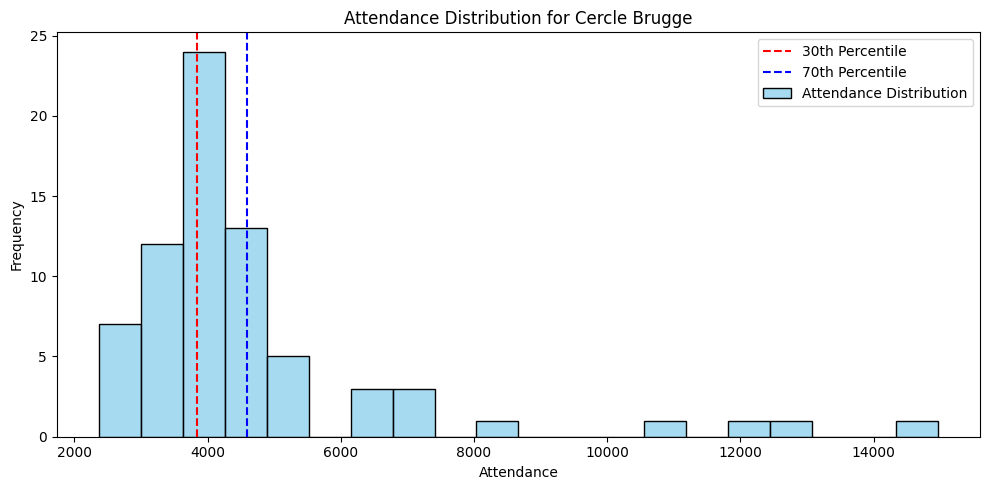

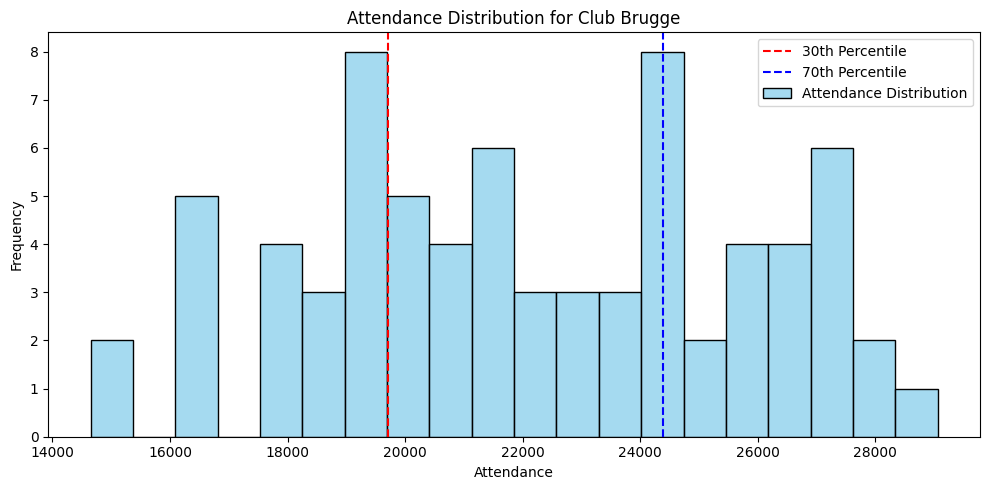

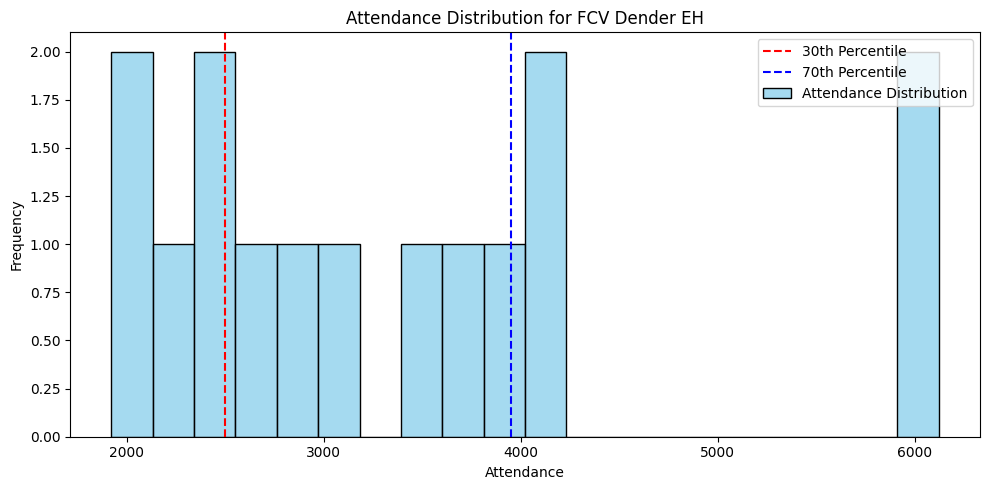

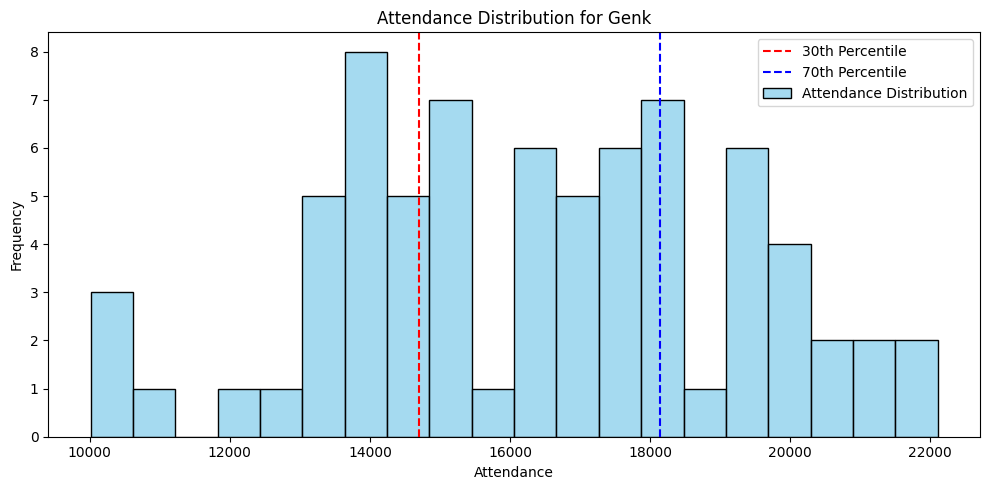

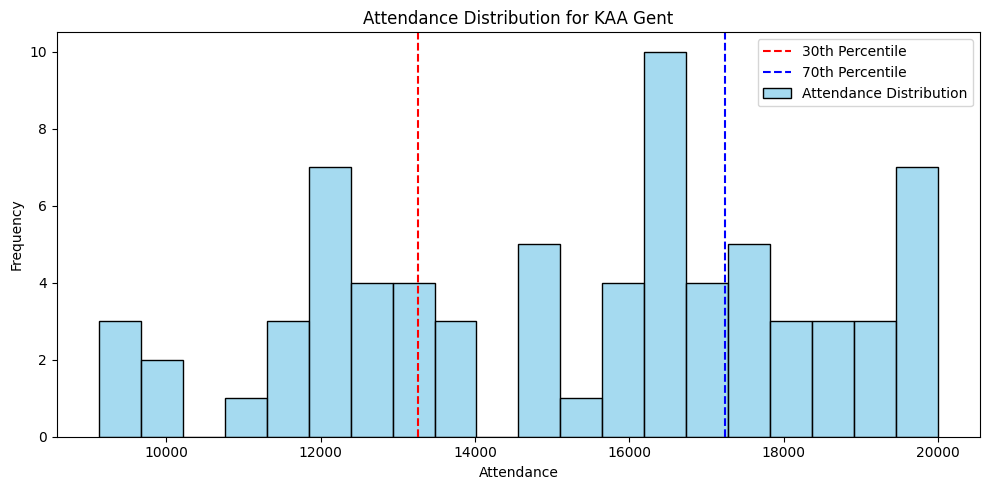

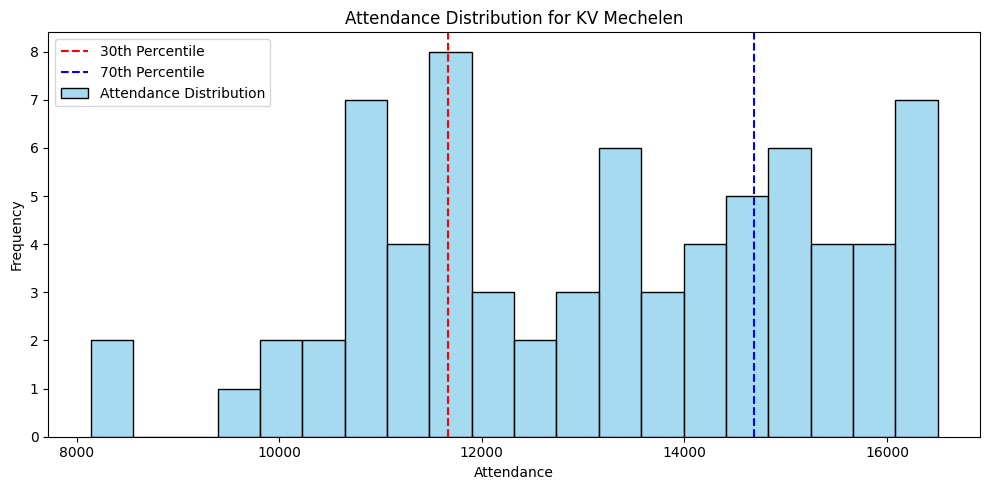

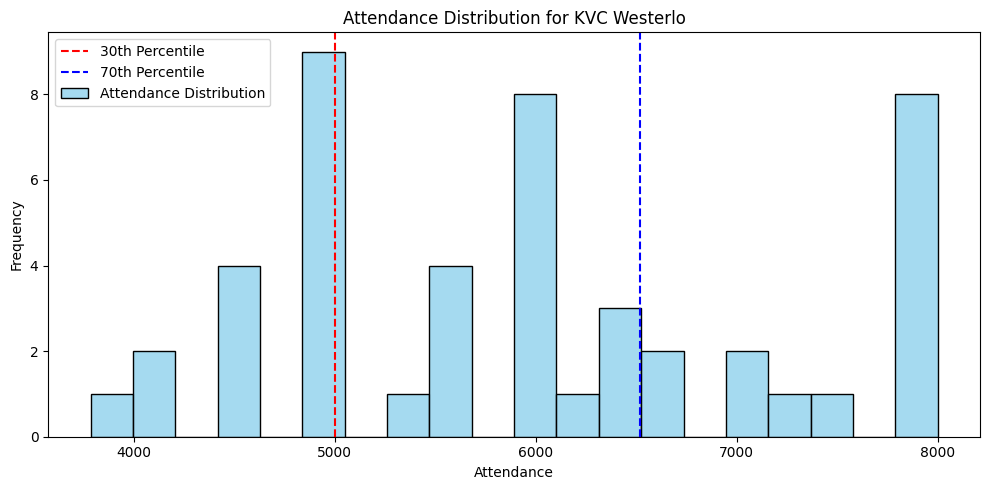

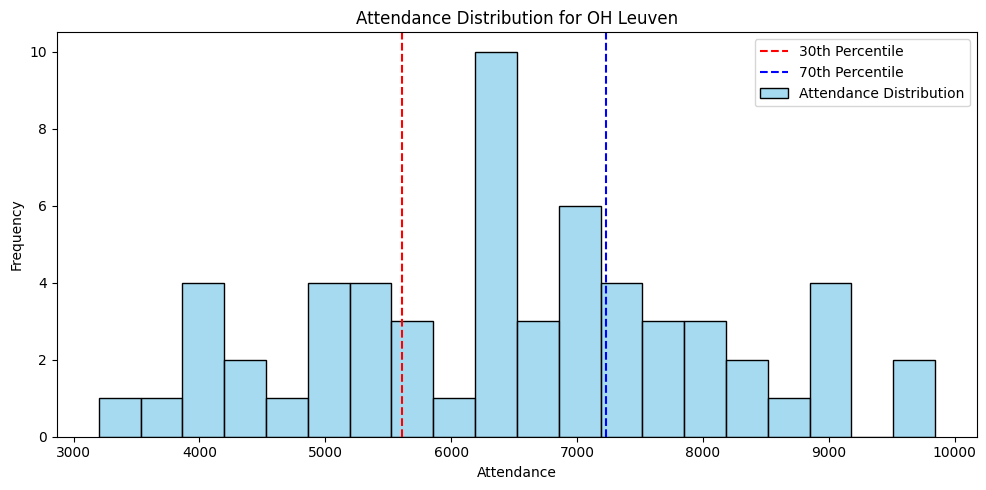

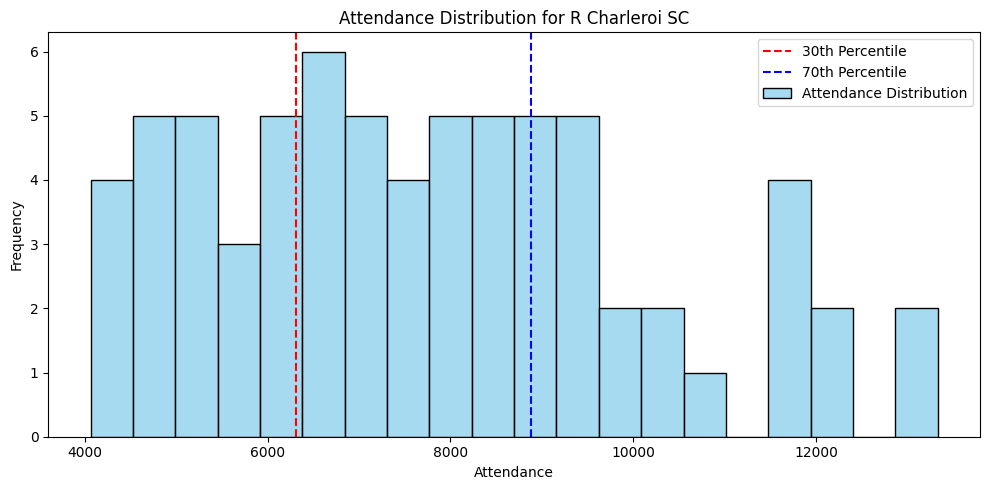

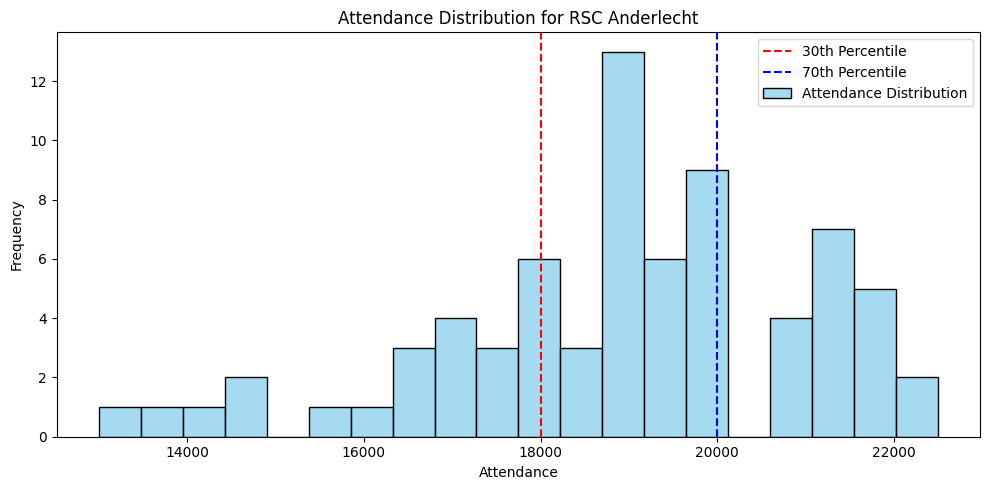

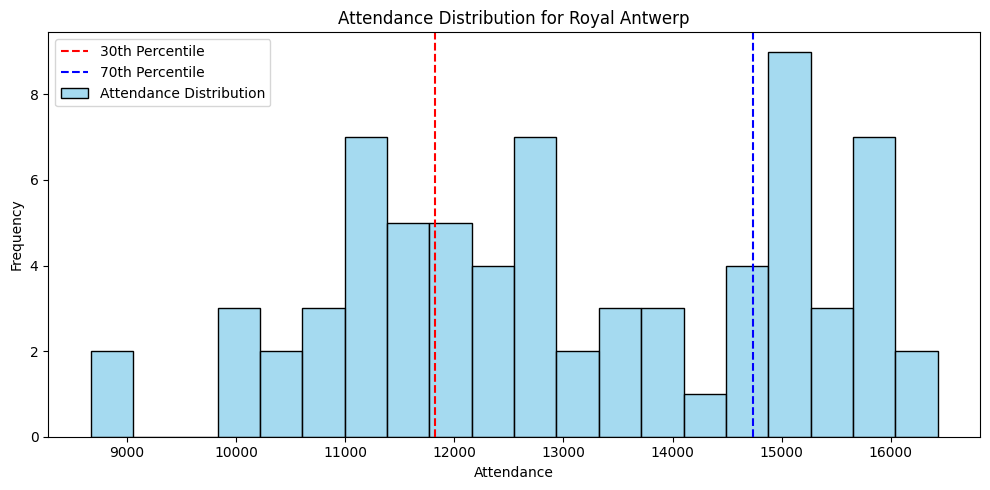

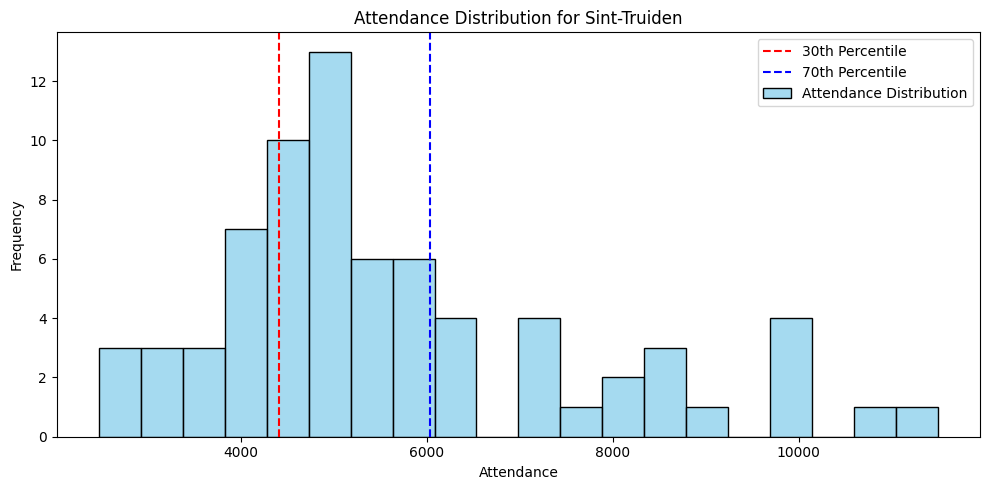

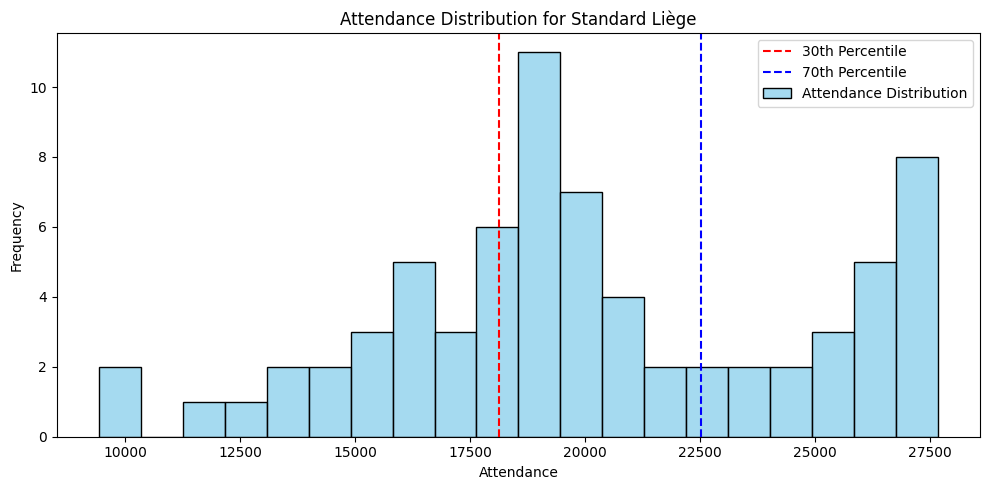

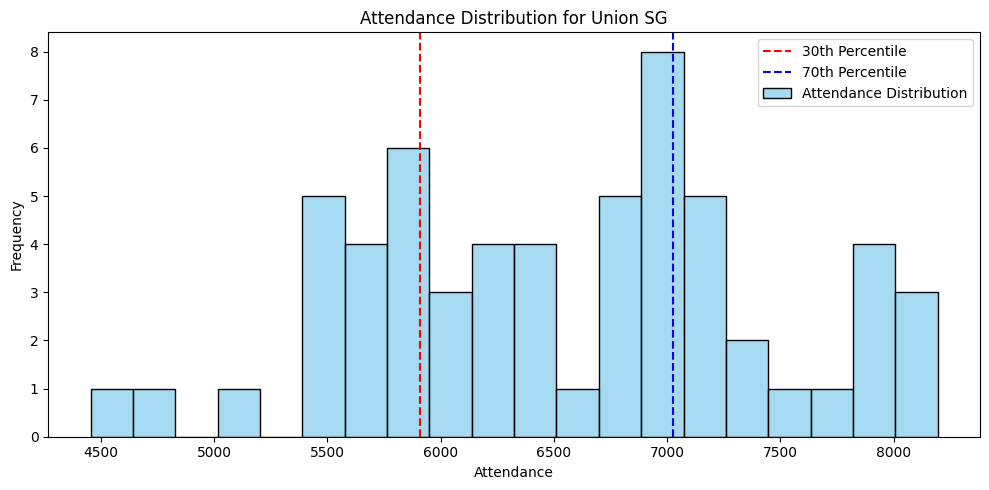

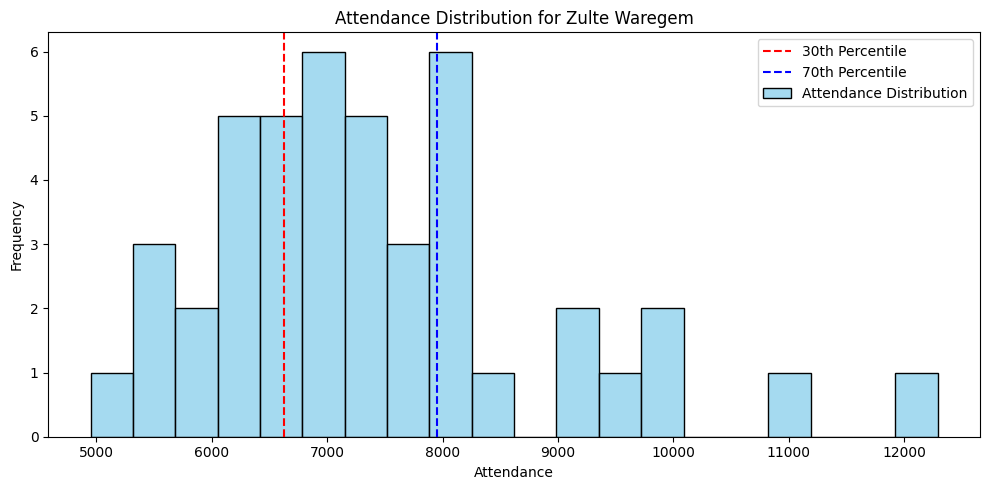

In [11]:
# Iterate through the different Home teams to visualise the specific Attendance Distributions for the Home Teams
for team in team_stats['Home Team']:
    team_data = df[df['Home Team'] == team]  # Filter data for the specific team
    attendance_30th = team_stats.loc[team_stats['Home Team'] == team, 'attendance_30th_percentile'].values[0]
    attendance_70th = team_stats.loc[team_stats['Home Team'] == team, 'attendance_70th_percentile'].values[0]

    plt.figure(figsize=(10, 5))
    sns.histplot(team_data['Attendance'], kde=False, bins=20, color="skyblue", label="Attendance Distribution")
    plt.axvline(attendance_30th, color='red', linestyle='--', label='30th Percentile')
    plt.axvline(attendance_70th, color='blue', linestyle='--', label='70th Percentile')
    plt.title(f"Attendance Distribution for {team}")
    plt.xlabel("Attendance")
    plt.ylabel("Frequency")
    plt.legend()
    plt.tight_layout()
    plt.show()

### Multicolinearity Check

In [12]:
# ======================================================
#   VIF — clean, self-contained, robust version
# ======================================================

import pandas as pd
import numpy as np
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 1) Define target & make a working copy
TARGET = "PercentageAttendance"
df_model = df.drop(columns=[TARGET], errors="ignore").copy()

# 2) Encode categorical cols safely
cat_cols = [
    "Matchday","Home Team","Away Team","Weekday",
    "Opposing team Category","Home team Category",
    "Game day","Time slot","Weather GoodBad","Weather"
]
df_model = pd.get_dummies(df_model, columns=cat_cols, drop_first=True)

# 3) Keep only numeric columns
df_model = df_model.select_dtypes(include=[np.number])

# 4) Coerce remaining weird stuff & fill NA
df_model = df_model.apply(pd.to_numeric, errors='coerce').fillna(0)

# 5) Add constant
X = add_constant(df_model)

# 6) Compute VIF
vif_df = pd.DataFrame({
    "Feature": X.columns,
    "VIF": [
        variance_inflation_factor(X.values, i)
        for i in range(X.shape[1])
    ]
}).sort_values("VIF", ascending=False)

vif_df


,Feature,VIF
0,const,5.189100e+07
8,Year,3.818088e+01
9,quarter,3.473759e+01
7,Month,3.349526e+01
1,match_id,3.270614e+01
14,GDP_Real_lagQ,2.474077e+01
16,Employment_Rate_%_lagQ,6.609234e+00
21,Number of Wins in Last 5 Games,2.950518e+00
15,CPI_QoQ_Growth_%_lagQ,2.360297e+00
5,Attendance,2.247330e+00


### Variance Inflation Factor (VIF) Analysis

VIF measures multicollinearity — values above 5–10 indicate problematic correlation between predictors.

**High VIF features removed:**
- **Year** (VIF > 15): Highly correlated with GDP_Real_lagQ (both capture time trends)
- **Quarter** (VIF > 10): Partially redundant with Month

**Retained despite moderate VIF:**
- **GDP_Real_lagQ** (VIF ~5.5): Kept as the primary economic indicator
- **match_id** (VIF ~15): Functions as a time proxy but retained for model tracking

Removing Year/Quarter reduced multicollinearity without losing predictive signal, as GDP already captures the relevant economic trends.

In [13]:
df = df.drop(columns=["Year", "quarter"], errors="ignore")

In [14]:
# ========== RECOMPUTE VIF TABLE (after dropping Year & quarter) ==========

import numpy as np
import pandas as pd
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

TARGET = "PercentageAttendance"

# 1) Copy df and remove target
df_model = df.drop(columns=[TARGET], errors="ignore").copy()

# 2) One-hot encode categoricals
cat_cols = [
    "Matchday","Home Team","Away Team","Weekday",
    "Opposing team Category","Home team Category",
    "Game day","Time slot","Weather GoodBad","Weather"
]
df_model = pd.get_dummies(df_model, columns=cat_cols, drop_first=True)

# 3) Keep numerics only, coerce and fill NaN
df_model = df_model.select_dtypes(include=[np.number]).apply(pd.to_numeric, errors="coerce").fillna(0)

# 4) Add constant
X = add_constant(df_model)

# 5) Compute VIF
vif_df = pd.DataFrame({
    "Feature": X.columns,
    "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
}).sort_values("VIF", ascending=False)

vif_df


,Feature,VIF
0,const,73282.762512
12,GDP_Real_lagQ,17.379600
1,match_id,15.778113
14,Employment_Rate_%_lagQ,5.502148
19,Number of Wins in Last 5 Games,2.944230
5,Attendance,2.231950
17,Goals Scored in Last 5 Games,1.993295
18,Goals Conceded in Last 5 Games,1.900850
3,Ranking Home Team,1.815081
13,CPI_QoQ_Growth_%_lagQ,1.776227


-----
We now see that there is no multicolinearity left

----


In [15]:
# We now remove teams that are not part of the 16 current jupiler league teams to avoid the creation of many dummy with almost no information that woud explode the number of columns. SO we put them all under the same box "unknown"
super_league_teams = [
    'Club Brugge', 'Cercle Brugge', 'Genk', 'RSC Anderlecht', 'Union SG', 'KAA Gent', 'Royal Antwerp', 'KVC Westerlo', 'Standard Liège', 'KV Mechelen', 'R Charleroi SC', 'OH Leuven', "Sint-Truiden", "FCV Dender EH", "Zulte Waregem", "La Louvière"
]

# Put all other teams as 'Unknown'
df['Away Team'] = df['Away Team'].apply(lambda team: team if team in super_league_teams else 'Unknown')

In [16]:
# Identification of categorial columns
categorical_columns = [
    "Matchday",
    "Home Team",
    "Away Team",
    "Weekday"
]

# Dummy-Encoding
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

In [17]:
# Identification of categorial columns, where complete Dummy-Codierung is used for easier Feature Importance Analysis later

categorial_columns_2 = [
    "Opposing team Category",
    "Home team Category",
    "Game day",
    "Time slot",
    "Weather GoodBad",
    "Weather",
]

df = pd.get_dummies(df, columns=categorial_columns_2, drop_first=False)

In [18]:
df = df.apply(pd.to_numeric, errors='ignore')

/var/folders/5c/wqf6h9_n6sbf0vf58y7rdgj40000gn/T/ipykernel_67883/1277559549.py:1: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


In [19]:
# checking how many ranks = 0
# Count rows with 0 in Home/Away ranking
home_zero = (df['Ranking Home Team'] == 0)
away_zero = (df['Ranking Away Team'] == 0)
either_zero = home_zero | away_zero

print("Rows with 0 in either ranking:", either_zero.sum())
print("  ├─ 0 in Ranking Home Team:", home_zero.sum())
print("  └─ 0 in Ranking Away Team:", away_zero.sum())

# (Optional) see the first few offending rows
display(df.loc[either_zero].head())


Rows with 0 in either ranking: 0
  ├─ 0 in Ranking Home Team: 0
  └─ 0 in Ranking Away Team: 0


,Competition,match_id,Date,Time,Ranking Home Team,Ranking Away Team,Attendance,PercentageAttendance,Temperature (°C),Month,...,Time slot_Afternoon,Time slot_Evening,Time slot_Night,Weather GoodBad_Bad,Weather GoodBad_Good,Weather_Clear or mostly clear,Weather_Drizzle,Weather_Partly cloudy,Weather_Rainy,Weather_Snowy


In [20]:
# Drop rows where either ranking is 0
mask_bad = (df['Ranking Home Team'] == 0) | (df['Ranking Away Team'] == 0)
n_bad = int(mask_bad.sum())

df = df.loc[~mask_bad].copy()
df.reset_index(drop=True, inplace=True)

print(f"Dropped {n_bad} rows with 0 in rankings. New shape: {df.shape}")
print("Any 0s left?",
      (df['Ranking Home Team'] == 0).any() or (df['Ranking Away Team'] == 0).any())


Dropped 0 rows with 0 in rankings. New shape: (944, 117)
Any 0s left? False


In [21]:
## Lastly we add a column match_id to simplify our life for the ERM that we will create afterwards.

df["match_id"] = range(1, len(df) + 1)
df.head()


,Competition,match_id,Date,Time,Ranking Home Team,Ranking Away Team,Attendance,PercentageAttendance,Temperature (°C),Month,...,Time slot_Afternoon,Time slot_Evening,Time slot_Night,Weather GoodBad_Bad,Weather GoodBad_Good,Weather_Clear or mostly clear,Weather_Drizzle,Weather_Partly cloudy,Weather_Rainy,Weather_Snowy
0,Jupiler Pro League,1,2019-07-26,20.0,7,11,16120.0,0.685957,30.0,7,...,False,False,True,False,True,False,False,True,False,False
1,Jupiler Pro League,2,2019-07-27,18.0,14,5,4311.0,0.148338,18.9,7,...,False,True,False,True,False,False,True,False,False,False
2,Jupiler Pro League,3,2019-07-27,20.0,9,6,7033.0,0.567177,18.7,7,...,False,False,True,True,False,False,True,False,False,False
3,Jupiler Pro League,4,2019-07-27,20.0,12,10,4338.0,0.297123,19.4,7,...,False,False,True,True,False,False,False,False,True,False
4,Jupiler Pro League,5,2019-07-28,18.0,3,2,8760.0,0.584000,19.4,7,...,False,True,False,True,False,False,True,False,False,False


### Data Preparation Notes

After loading from the database, the dataset undergoes several cleaning steps:
- **Attendance capping**: Values exceeding 100% capacity are clipped to 1.0 (likely data entry errors or standing-room situations)
- **Categorical encoding**: Team names, weather types, weekdays, and time slots are one-hot encoded
- **Multicollinearity check**: Year and Quarter are dropped due to high VIF with GDP (which already captures temporal economic trends)
- **COVID exclusions**: Matches with attendance restrictions during 2020–2021 are excluded from modeling (122 matches removed)

Final modeling dataset: **822 matches** (708 train / 236 test with 75/25 split, random_state=42)

## **Data Exploration**

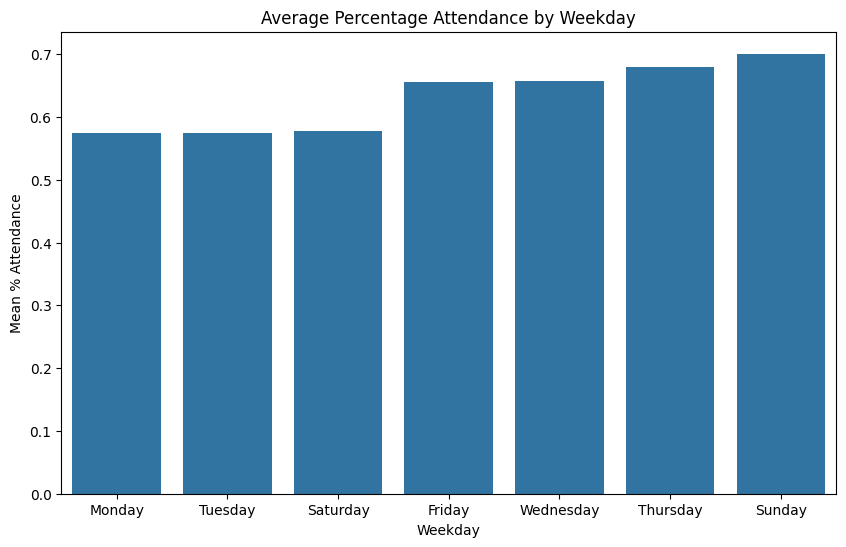

In [22]:
# --- reload clean data JUST for plotting, do NOT overwrite df ---
df_plot = pd.read_csv(path + "CleanedData.csv")

plt.figure(figsize=(10,6))
mean_att = (
    df_plot.groupby("Weekday")["PercentageAttendance"]
    .mean()
    .sort_values()
)

sns.barplot(x=mean_att.index, y=mean_att.values)
plt.title("Average Percentage Attendance by Weekday")
plt.ylabel("Mean % Attendance")
plt.show()


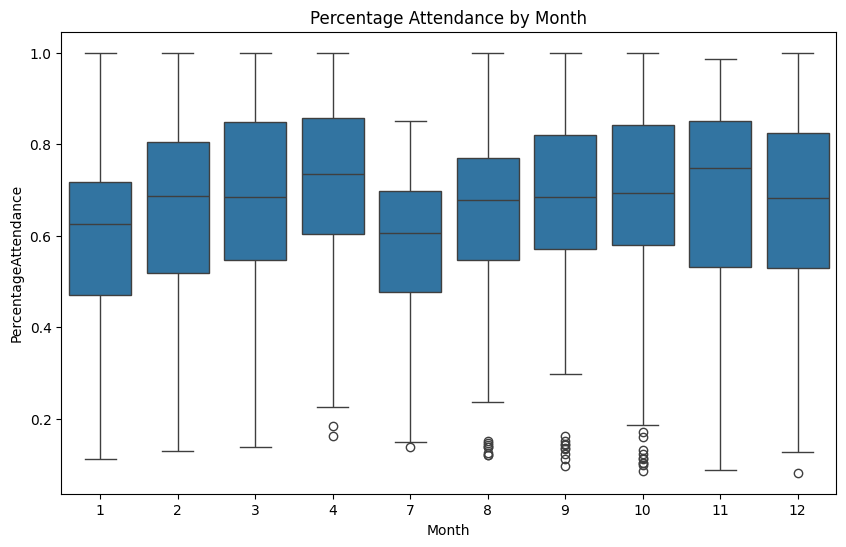

In [23]:
##Influence of the Month on percentage Attendance
plt.figure(figsize=(10, 6))
sns.boxplot(x='Month', y='PercentageAttendance', data=df)
plt.title("Percentage Attendance by Month")
plt.show()

----

Higher medians in spring and late autumn (≈ Mar–May and Oct–Nov). Distributions are tighter too → more consistently high attendance.

Dip in early summer (≈ Jun–Jul): lower medians and lower upper whiskers → fewer sell-outs, more variability.

Winter (Jan–Feb, Dec) looks middling: medians around ~0.6–0.7 with wider spread.

Outliers (very low % games) pop up mainly around Aug–Oct and Dec—likely weather-affected matches, awkward kick-off times, or low-draw fixtures.

Why this might happen:

Fixture importance rises toward the run-in (Apr–May) and again in autumn after the season settles.

Summer break/holidays and friendlies/qualifiers can depress club attendance in Jun–Jul.

Weather & holidays (cold snaps, Xmas period) add variance in winter months.

---

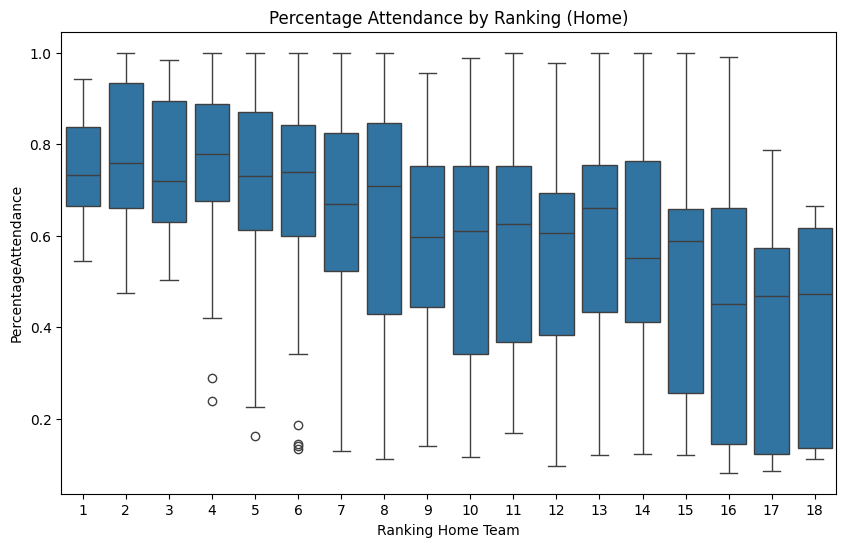

In [24]:
#Influence of Home Team Ranking on percentage Attendance
plt.figure(figsize=(10, 6))
sns.boxplot(x='Ranking Home Team', y='PercentageAttendance', data=df)
plt.title("Percentage Attendance by Ranking (Home)")
plt.show()

---

Clear downward trend: As the home team’s rank number increases (team is worse), the median percentage attendance steps down. Ranks 1–5 sit around the highest medians (~0.7–0.8), while 15–18 drop notably (~0.45–0.6).

Spread widens for weaker teams: From about rank 10 onward, the boxes get taller and the lower whiskers/outliers dip more. That means weaker home teams not only draw less on average, they’re less consistent—more very low-attendance games.

Ceiling persists across ranks: The top whiskers touch ~1.0 almost everywhere. So even poorly ranked teams can sell out on the right night (derbies, marquee opponents, decisive fixtures).

Kinks rather than perfectly linear: It’s not a smooth slope—there’s a fairly flat plateau around ranks ~5–9, then a sharper drop after ~12–13, and the steepest fall sits in the 15–18 range.

Takeaways

Home team quality is a strong driver of turnout (in percentage terms, so capacity isn’t the culprit).

Variability grows as quality drops → planning risk is higher for lower-ranked teams.

Big-match effects can override rank, producing near-sellouts at any rank.

---

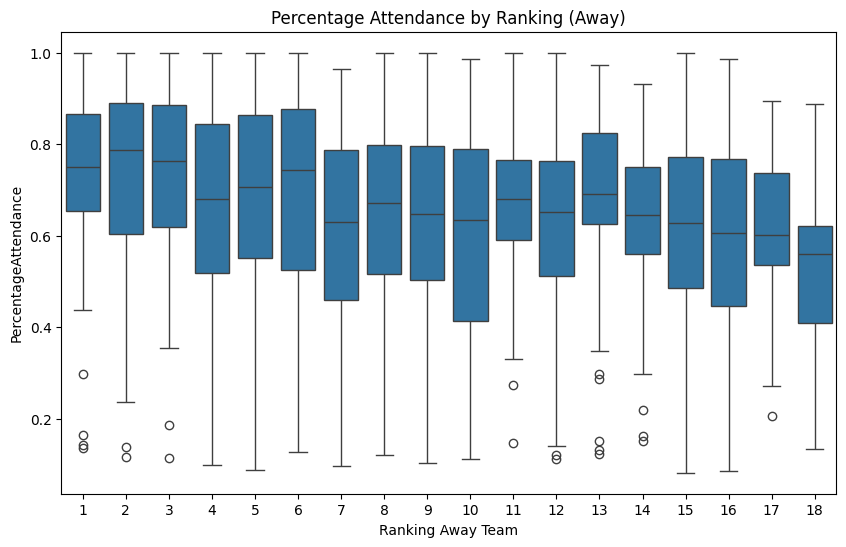

In [25]:
#Influence of Away Team Ranking on percentage Attendance
plt.figure(figsize=(10, 6))
sns.boxplot(x='Ranking Away Team', y='PercentageAttendance', data=df)
plt.title("Percentage Attendance by Ranking (Away)")
plt.show()

---

Mild downward trend: Better away teams (rank 1–4) tend to draw slightly higher median attendance (~0.70–0.80). As the away rank number increases (weaker team), the median drifts down toward ~0.55–0.65 by ranks 15–18. So away quality matters—but only moderately.

Bigger spread for weaker visitors: From about ranks 10–18 the boxes widen and low-end whiskers/outliers dip more. That means “bad” away teams produce more volatile turnouts—some nights okay, some very poor.

High ceiling across all ranks: Upper whiskers touch ~1.0 for most ranks. Even weak visitors can fill the place when other factors are favorable (derbies, decisive fixtures, weekends, good weather, strong home side).

Nonlinear shape: It’s not a straight line—there’s a plateau around mid-table and sharper drops at the bottom ranks. Encode rank with bins/splines or treat as categorical rather than purely linear.

Likely confounders: Capacity capping (percentage capped at 1), home-team strength, derby flag, kickoff time/day, and competition stage can all override away rank.

---

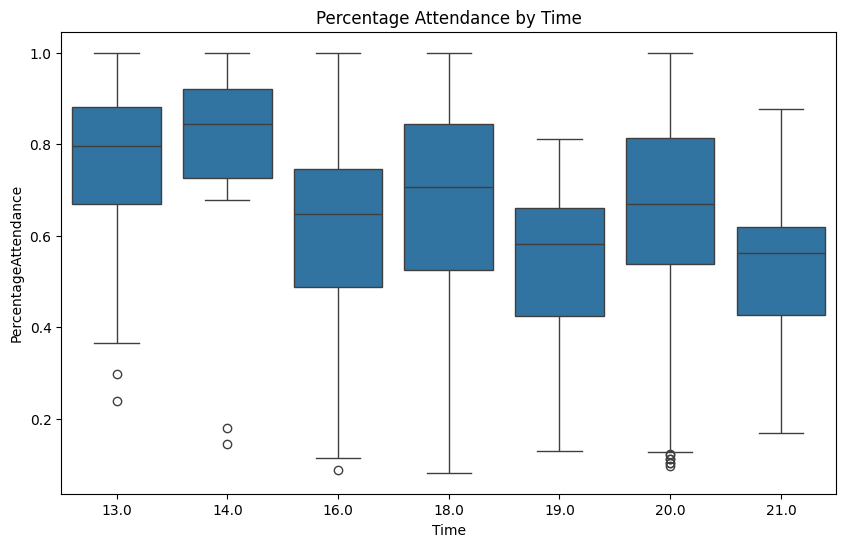

In [26]:
#Influence of Time on percentage Attendance
plt.figure(figsize=(10, 6))
sns.boxplot(x='Time', y='PercentageAttendance', data=df)
plt.title("Percentage Attendance by Time")
plt.show()

---

Best turnout: 13:00–14:00 have the highest medians (~0.8–0.9) and relatively tight boxes → reliably strong crowds.

OK: 18:00–20:00 sit in the middle (medians ~0.65–0.75) with more spread → decent but less consistent.

Weaker: 19:00 and 21:00 look lower (~0.55–0.6) and more variable → more nights with half-full stands.

Risky slot: 16:00 shows wide variance and very low outliers (~0.1) → occasionally poor attendance.

Ceiling effect: Upper whiskers touch 1.0 across times, so sell-outs can still happen at any slot (derbies, big opponents, etc.).

---

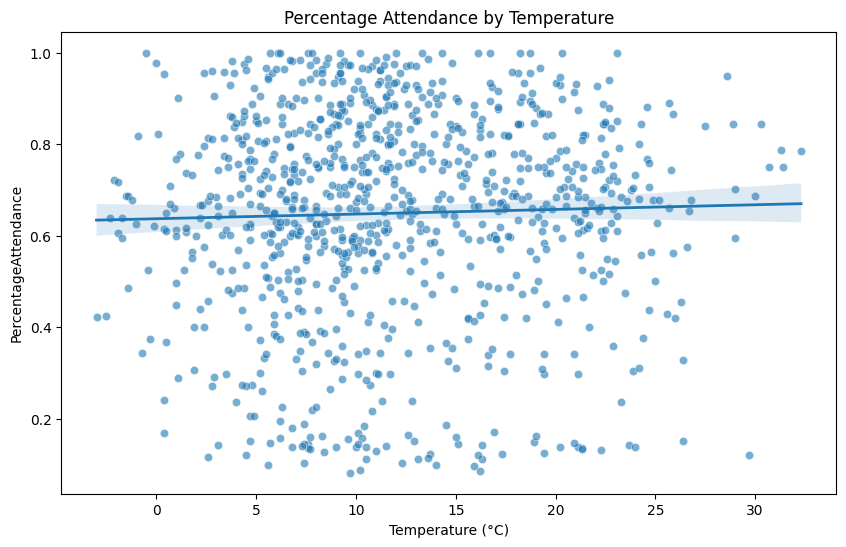

In [27]:
#Influence of Temperature on percentage Attendance
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(x='Temperature (°C)', y='PercentageAttendance', data=df, alpha=0.6)

# add linear trendline (with 95% CI band)
sns.regplot(
    x='Temperature (°C)', y='PercentageAttendance', data=df,
    scatter=False, ci=95, ax=ax, line_kws={'linewidth': 2}
)

plt.title("Percentage Attendance by Temperature")
plt.show()


---

The cloud of points is very wide at every temperature and the trendline is almost flat with a tiny positive slope → very weak association.

So moving from, say, 5 °C to 25 °C barely shifts expected attendance percentage.

Temperature alone won’t be a good predictor; other factors (team quality, derby/importance, day/time, capacity, rain/snow) likely dominate.

---

In [28]:
# Drop weather-related columns
weather_cols = [
    c for c in df.columns
    if c.startswith('Weather_')              # detailed weather dummies
    or c.startswith('Weather GoodBad_')      # Good/Bad dummies
    or c in ('WeatherGoodBad', 'Weather GoodBad', 'Temperature (°C)', 'Weather')  # temperature & raw weather col
]

df_without_weather = df.drop(columns=weather_cols, errors='ignore')

# Define target and features for the model without weather
target = "PercentageAttendance"

X_without_weather = (
    df_without_weather
        .drop(columns=[target])
        .select_dtypes(include=['number', 'bool'])  # keep numeric + bool
        .astype(float)                              # turn bools into 0.0/1.0
)

y_without_weather = df_without_weather[target].astype(float)

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split

X_train_without_weather, X_test_without_weather, y_train_without_weather, y_test_without_weather = train_test_split(
    X_without_weather, y_without_weather, test_size=0.25, random_state=42
)


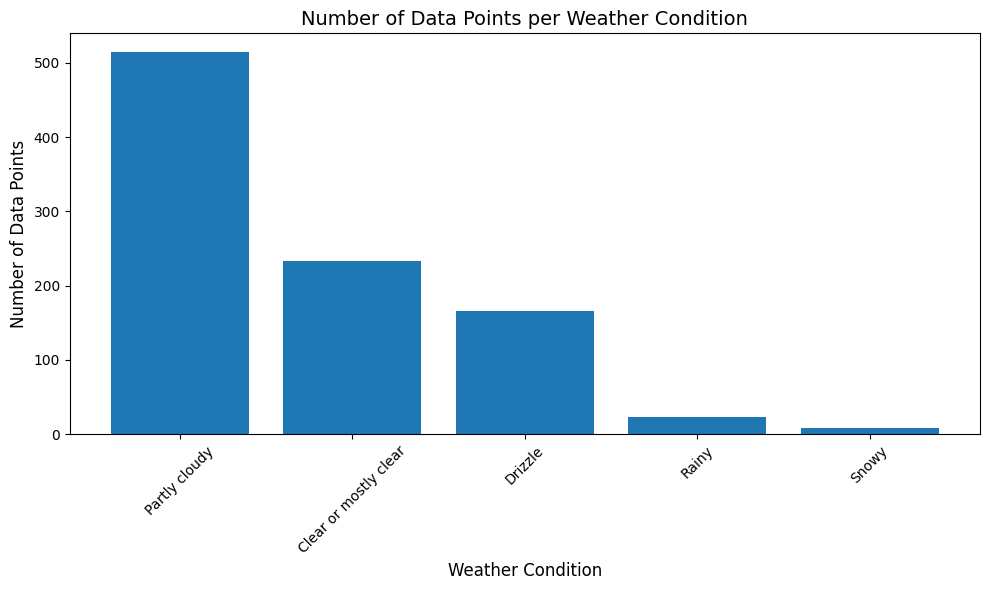

In [29]:
# Count number of Datapoints per Weather Condition
weather_conditions = [ 'Weather_Clear or mostly clear','Weather_Partly cloudy',
                      'Weather_Rainy', 'Weather_Drizzle', 'Weather_Snowy']

#Count number of Data Points for each weather condition
weather_counts = {weather.split('_')[-1]: df[weather].sum() for weather in weather_conditions}

#convert to Dataframe
weather_counts_df = pd.DataFrame(list(weather_counts.items()), columns=['Weather Condition', 'Count'])

# Sort
weather_counts_df = weather_counts_df.sort_values(by='Count', ascending=False)

# Visualize
plt.figure(figsize=(10, 6))
plt.bar(weather_counts_df['Weather Condition'], weather_counts_df['Count'])
plt.xlabel('Weather Condition', fontsize=12)
plt.ylabel('Number of Data Points', fontsize=12)
plt.title('Number of Data Points per Weather Condition', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

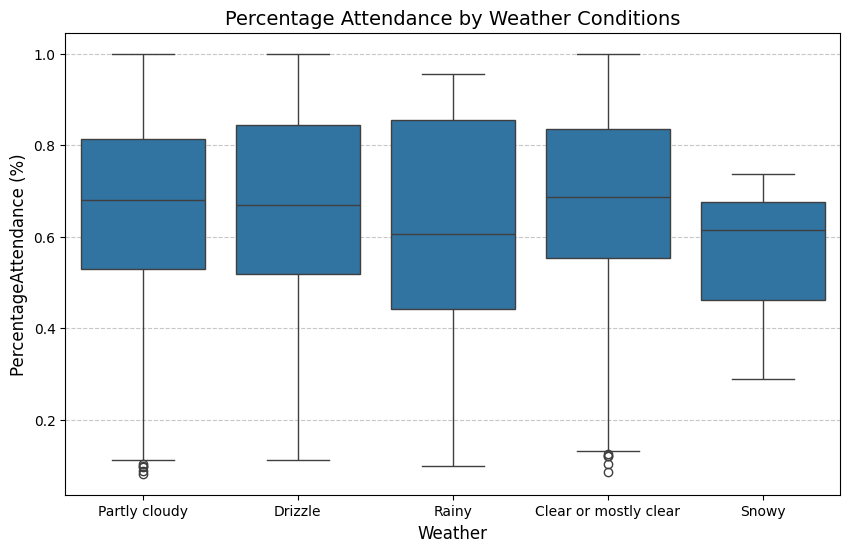

In [30]:
# Recreate a categorical Weather label from one-hot columns
weather_cols = [c for c in df.columns if c.startswith('Weather_') and c != 'Weather_GoodBad']
weather_label = (
    df[weather_cols]
    .idxmax(axis=1)              # e.g. 'Weather_Rainy'
    .str.replace('Weather_', '', regex=False)
    .fillna('Unknown')
)

plot_df = pd.DataFrame({
    'Weather': weather_label,
    'PercentageAttendance': df['PercentageAttendance']
})

plt.figure(figsize=(10, 6))
sns.boxplot(x='Weather', y='PercentageAttendance', data=plot_df)
plt.title('Percentage Attendance by Weather Conditions', fontsize=14)
plt.xlabel('Weather', fontsize=12)
plt.ylabel('PercentageAttendance (%)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


---

**Exploratory observation**: The boxplot shows lower median attendance on rainy and snowy days, with compressed variance. However, this visual pattern may be misleading for two reasons:

1. **Sample size imbalance**: Clear/partly cloudy days dominate the dataset (~70%), while rainy (~15%) and snowy (<5%) days are underrepresented. The apparent "effect" could be noise from small samples.

2. **Confounding factors**: Bad weather days may correlate with other attendance drivers (e.g., midweek winter fixtures against lower-ranked opponents). The visual correlation doesn't imply causation.

We'll test whether weather *actually* improves predictions in the modeling section.

---

## **Model**

In [31]:
# Drop the raw Attendance column from the dataset (keep PercentageAttendance as target)
if 'Attendance' in df.columns:
    df = df.drop(columns=['Attendance'])
    print("Dropped column: Attendance")
else:
    print("Column 'Attendance' not found; nothing to drop.")


Dropped column: Attendance


In [32]:
target = "PercentageAttendance"

# keep only numeric + bool predictors, then cast everything to float
X_weather_num = (
    df.drop(columns=[target])
      .select_dtypes(include=['number', 'bool'])
      .astype(float)          # 🔑 this avoids the statsmodels object-dtype error
)

y_weather = df[target].astype(float)

from sklearn.model_selection import train_test_split

X_train_weather, X_test_weather, y_train_weather, y_test_weather = train_test_split(
    X_weather_num, y_weather, test_size=0.25, random_state=42
)

import statsmodels.api as sm

X_train_linreg_weather = sm.add_constant(X_train_weather)
linreg_weather = sm.OLS(y_train_weather, X_train_linreg_weather).fit()


In [33]:
X_train_weather

,match_id,Time,Ranking Home Team,Ranking Away Team,Temperature (°C),Month,Day,Derby,Max Capacity,Full Roof,...,Time slot_Afternoon,Time slot_Evening,Time slot_Night,Weather GoodBad_Bad,Weather GoodBad_Good,Weather_Clear or mostly clear,Weather_Drizzle,Weather_Partly cloudy,Weather_Rainy,Weather_Snowy
584,585.0,20.0,6.0,11.0,12.8,9.0,23.0,0.0,16644.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
298,299.0,18.0,5.0,6.0,6.6,4.0,3.0,0.0,22500.0,1.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
828,829.0,18.0,9.0,12.0,9.0,11.0,9.0,0.0,6200.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
328,329.0,16.0,14.0,9.0,31.4,8.0,13.0,0.0,8000.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
204,205.0,18.0,15.0,10.0,9.0,11.0,20.0,0.0,12400.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,107.0,20.0,11.0,2.0,7.4,12.0,22.0,0.0,14600.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
270,271.0,13.0,2.0,3.0,6.7,2.0,27.0,0.0,29062.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
860,861.0,20.0,10.0,7.0,5.8,12.0,20.0,0.0,8000.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
435,436.0,18.0,10.0,7.0,10.5,1.0,7.0,0.0,29062.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [34]:
#Function to save the results of the different models in a dataframe for easier comparison / visualization

#Dataframe
results = pd.DataFrame(columns=["Model", "MSE", "RMSE", "R2"])

def evaluate_model(model_name, y_test, y_pred, results_df):

    #Calculation of metrics
    mse_value = mean_squared_error(y_test, y_pred)
    rmse_value = np.sqrt(mse_value)
    r2_value = r2_score(y_test, y_pred)

    # Add results to the Dataframe
    results_df = pd.concat([
        results_df,
        pd.DataFrame({
            "Model": [model_name],
            "MSE": [mse_value],
            "RMSE": [rmse_value],
            "R2": [r2_value]
        })
    ], ignore_index=True)

    return results_df

### Modeling Approach

We compare four model families, each trained in two variants:
- **With weather**: Includes temperature, weather type dummies (Clear, Drizzle, Rainy, Snowy, Partly cloudy), Weather GoodBad classification, and Full Roof indicator
- **Without weather**: Excludes all weather-related features

This controlled comparison isolates the marginal contribution of weather data. If weather features add predictive value, models "with weather" should consistently outperform their counterparts.

**Train/test split**: 75/25, stratified by random_state=42 for reproducibility. Both variants use the same split to ensure fair comparison.

**Evaluation metrics**: 
- **R²** (primary): Proportion of variance explained — higher is better
- **RMSE**: Root mean squared error in percentage points — lower is better

### Linear Regression

#### Linear Regression with Weather

In [35]:
#Add constant to the Trainingsset
X_train_linreg_weather = sm.add_constant(X_train_weather)

#Create Model and Fit
linreg_weather = sm.OLS(y_train_weather, X_train_linreg_weather).fit()

In [36]:
#Add Constant to the Testset
X_test_linreg_weather = sm.add_constant(X_test_weather)

#Make Prediction
y_pred_linreg_weather = linreg_weather.predict(X_test_linreg_weather)

In [37]:
#Save rsults to the Dataframe
results = evaluate_model("Linear Regression (weather)", y_test_weather, y_pred_linreg_weather, results)

/var/folders/5c/wqf6h9_n6sbf0vf58y7rdgj40000gn/T/ipykernel_67883/4031908317.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([


#### Linear Regression without Weather

In [38]:
# Drop weather-related columns
weather_cols = [
    c for c in df.columns
    if c.startswith('Weather_')              # detailed weather dummies
    or c.startswith('Weather GoodBad_')      # Good/Bad dummies
    or c in ('WeatherGoodBad', 'Weather GoodBad')  # raw col, just in case
]

df_without_weather = df.drop(columns=weather_cols, errors='ignore')

# Define target and features for the model without weather
target = "PercentageAttendance"

X_without_weather = (
    df_without_weather
        .drop(columns=[target])
        .select_dtypes(include=['number', 'bool'])  # keep numeric + bool
        .astype(float)                              # turn bools into 0.0/1.0
)

y_without_weather = df_without_weather[target].astype(float)

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split

X_train_without_weather, X_test_without_weather, y_train_without_weather, y_test_without_weather = train_test_split(
    X_without_weather, y_without_weather, test_size=0.25, random_state=42
)


In [39]:
#Add constant to the Training set
X_train_linreg_without_weather = sm.add_constant(X_train_without_weather)

#Create Model and Fit
linreg_without_weather = sm.OLS(y_train_without_weather, X_train_linreg_without_weather).fit()

In [40]:
# 1) Build test design matrix to match training features
feat_cols = [c for c in linreg_without_weather.model.exog_names if c != "const"]   # columns used in training

X_test = (
    X_test_without_weather
      .select_dtypes(include=[np.number])      # numeric only
      .replace([np.inf, -np.inf], np.nan)
      .reindex(columns=feat_cols, fill_value=0)  # align to training cols
)
X_test = sm.add_constant(X_test, has_constant='add')

# 2) Predict
y_pred_linreg_without_weather = linreg_without_weather.predict(X_test)


In [41]:
#Save rsults to the Dataframe
results = evaluate_model("Linear Regression (without weather)", y_test_without_weather, y_pred_linreg_without_weather, results)

#### Log Linear Regression with Weather

In [42]:
eps = 1e-6
y_log = np.log(y_train_weather.clip(eps, None))
X_tr = sm.add_constant(X_train_weather, has_constant='add')
log_lin = sm.OLS(y_log, X_tr).fit()

X_te = sm.add_constant(X_test_weather, has_constant='add')
log_pred = log_lin.predict(X_te)

# Duan smearing
smear = np.mean(np.exp(log_lin.resid))
y_pred_log_linreg_weather = np.exp(log_pred) * smear


In [43]:
#Save rsults to the Dataframe
results = evaluate_model("Log Linear Regression (weather)", y_test_weather, y_pred_log_linreg_weather, results)

#### Log Linear Regression without weather

In [44]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# 1) TRAIN matrix — numeric only, clean infs/NaNs, and **drop any target-ish cols**
X_tr = X_train_without_weather.select_dtypes(include=[np.number]).replace([np.inf, -np.inf], np.nan)

# prevent leakage from any attendance-related columns that might have slipped in
possible_target_names = {'Attendance', 'PercentageAttendance'}
if hasattr(y_train_without_weather, 'name') and y_train_without_weather.name:
    possible_target_names.add(y_train_without_weather.name)
leaky_cols = [c for c in X_tr.columns if c in possible_target_names or c.lower().startswith('attendance')]
X_tr = X_tr.drop(columns=leaky_cols, errors='ignore')

# handle NaNs (drop or impute — here we drop for simplicity)
X_tr = X_tr.drop(columns=X_tr.columns[X_tr.isna().any()])

# y numeric & aligned
y_tr = pd.to_numeric(y_train_without_weather, errors='coerce')
mask = y_tr.notna()
X_tr, y_tr = X_tr.loc[mask], y_tr.loc[mask]

# 2) Logit-transform the target safely
eps = 1e-6
y_tr_clip = y_tr.clip(eps, 1 - eps)
y_tr_logit = np.log(y_tr_clip / (1 - y_tr_clip))

# 3) Add intercept and fit
X_tr = sm.add_constant(X_tr, has_constant='add')
logit_linreg_wo_weather = sm.OLS(y_tr_logit, X_tr, missing='drop').fit()

# 4) TEST matrix — **same columns as training**
feat_cols = [c for c in logit_linreg_wo_weather.model.exog_names if c != "const"]
X_te = (X_test_without_weather
        .select_dtypes(include=[np.number])
        .replace([np.inf, -np.inf], np.nan)
        .reindex(columns=feat_cols, fill_value=0))
X_te = sm.add_constant(X_te, has_constant='add')

# 5) Predict and inverse-logit back to (0,1), with tiny clip for safety
y_pred_logit_wo_weather = logit_linreg_wo_weather.predict(X_te)
y_pred_log_linreg_without_weather = 1 / (1 + np.exp(-y_pred_logit_wo_weather))
y_pred_log_linreg_without_weather = np.clip(y_pred_log_linreg_without_weather, eps, 1 - eps)

# (optional) paranoia check
assert not any(c in logit_linreg_wo_weather.model.exog_names for c in ['Attendance', 'PercentageAttendance']), \
    "Target leaked into design matrix!"


In [45]:
#Save rsults to the Dataframe
results = evaluate_model("Log Linear Regression (without weather)", y_test_without_weather, y_pred_log_linreg_without_weather, results)

### Tree Based Models

#### Random Forest

In [46]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer

def run_rf(
    X_train, X_test, y_train, y_test,
    label, results_df,
    n_estimators=100, max_depth=6, random_state=42,
    impute="drop"  # "drop" (drop cols with NaNs) or "median" (impute)
):
    # --- numeric-only + clean infs ---
    X_tr = X_train.select_dtypes(include=[np.number]).replace([np.inf, -np.inf], np.nan).copy()
    X_te = X_test.select_dtypes(include=[np.number]).replace([np.inf, -np.inf], np.nan).copy()

    # --- prevent target leakage ---
    possible_target_names = {'Attendance', 'PercentageAttendance'}
    if hasattr(y_train, 'name') and y_train.name:
        possible_target_names.add(y_train.name)
    leaky_cols = [c for c in X_tr.columns if c in possible_target_names or c.lower().startswith('attendance')]
    X_tr.drop(columns=leaky_cols, errors='ignore', inplace=True)
    X_te.drop(columns=leaky_cols, errors='ignore', inplace=True)

    # --- handle NaNs (choose one approach) ---
    if impute == "median":
        imp = SimpleImputer(strategy="median")
        X_tr = pd.DataFrame(imp.fit_transform(X_tr), columns=X_tr.columns, index=X_tr.index)
        X_te = pd.DataFrame(imp.transform(X_te.reindex(columns=X_tr.columns)), columns=X_tr.columns, index=X_te.index)
    else:  # drop columns with any NaN
        bad_cols = X_tr.columns[X_tr.isna().any()]
        X_tr = X_tr.drop(columns=bad_cols)
        X_te = X_te.reindex(columns=X_tr.columns, fill_value=0)

    # --- target numeric & aligned ---
    y_tr = pd.to_numeric(y_train, errors='coerce')
    mask = y_tr.notna()
    X_tr, y_tr = X_tr.loc[mask], y_tr.loc[mask]

    # --- fit & predict ---
    rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)
    rf.fit(X_tr, y_tr)
    y_pred = rf.predict(X_te)

    # --- log results ---
    results_df = evaluate_model(f"Random Forest ({label})", y_test, y_pred, results_df)
    return y_pred, results_df, rf

# ---------- Run it for both variants ----------
# Choose impute="median" if you want to keep all columns; "drop" is stricter.
_yp_w, results, rf_with_weather = run_rf(
    X_train_weather, X_test_weather, y_train_weather, y_test_weather,
    label="weather", results_df=results, impute="median"
)

_yp_wo, results, rf_without_weather = run_rf(
    X_train_without_weather, X_test_without_weather, y_train_without_weather, y_test_without_weather,
    label="without weather", results_df=results, impute="median"
)


In [47]:
#Save rsults to the Dataframe
results = evaluate_model("Random Forest (weather)", y_test_weather, _yp_w, results)

In [48]:
#Save rsults to the Dataframe
results = evaluate_model("Random Forest (without weather)", y_test_without_weather, _yp_wo, results)

#### XGBoost

In [49]:
from scipy.stats import randint, uniform, loguniform
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

# --- Build TRAIN matrix (numeric-only, handle inf/NaN), drop target-ish cols ---
Xtr_weather = (X_train_weather
               .select_dtypes(include=[np.number])
               .replace([np.inf, -np.inf], np.nan))     # keep NaNs (XGB can handle them)

possible_target_names = {'Attendance', 'PercentageAttendance'}
if hasattr(y_train_weather, 'name') and y_train_weather.name:
    possible_target_names.add(y_train_weather.name)
leaky = [c for c in Xtr_weather.columns if c in possible_target_names or c.lower().startswith('attendance')]
Xtr_weather = Xtr_weather.drop(columns=leaky, errors='ignore')

# Target numeric + align rows (drop rows where y is NaN)
ytr_weather = pd.to_numeric(y_train_weather, errors='coerce')
mask = ytr_weather.notna()
Xtr_weather, ytr_weather = Xtr_weather.loc[mask], ytr_weather.loc[mask]

# --- Model + search space ---
xgb_base = XGBRegressor(
    objective="reg:squarederror",
    tree_method="hist",        # fast & good default
    random_state=42
)

param_dist_wide = {
    # go both lower/faster and higher/slower than your current best
    "n_estimators": randint(300, 1200),
    # try smaller lrs with more trees and a bit larger too
    "learning_rate": loguniform(0.01, 0.2),   # ~0.01–0.2
    "max_depth": randint(3, 9),               # 3–8
    "min_child_weight": randint(1, 11),       # 1–10
    "subsample": uniform(0.5, 0.5),           # 0.5–1.0
    "colsample_bytree": uniform(0.5, 0.5),    # 0.5–1.0

    # add regularization & split penalty
    "gamma": uniform(0.0, 5.0),               # 0–5
    "reg_alpha": loguniform(1e-4, 1e0),       # L1: 1e-4–1
    "reg_lambda": loguniform(1e-2, 1e1),      # L2: 1e-2–10
}

rs1 = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist_wide,
    n_iter=60,                # bump a bit for the bigger space
    scoring="neg_mean_squared_error",
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

rs1.fit(Xtr_weather, ytr_weather)
best1 = rs1.best_estimator_
print("Stage-1 best:", rs1.best_params_)


Fitting 3 folds for each of 60 candidates, totalling 180 fits
Stage-1 best: {'colsample_bytree': np.float64(0.8238450602706812), 'gamma': np.float64(0.002601884976579094), 'learning_rate': np.float64(0.028754290605607913), 'max_depth': 5, 'min_child_weight': 7, 'n_estimators': 1009, 'reg_alpha': np.float64(0.01104051190316225), 'reg_lambda': np.float64(0.1787446325623842), 'subsample': np.float64(0.6110539052353652)}


In [50]:
from scipy.stats import uniform, loguniform, randint

best = rs1.best_params_

def clipped_uniform_01(center, halfwidth, lo_floor=0.5):
    lo = max(lo_floor, center - halfwidth)
    hi = min(1.0, center + halfwidth)
    # ensure positive scale
    return uniform(loc=lo, scale=max(1e-9, hi - lo))

param_dist_narrow = {
    "n_estimators": randint(int(best["n_estimators"]*0.6), int(best["n_estimators"]*1.6)),
    "learning_rate": loguniform(max(best["learning_rate"]/2, 1e-4), min(best["learning_rate"]*2, 3e-1)),
    "max_depth": randint(max(3, best["max_depth"]-2), min(10, best["max_depth"]+3)),
    "min_child_weight": randint(max(1, best["min_child_weight"]-3), best["min_child_weight"]+4),

    # ⬇️ CLIPPED distributions in [0, 1]
    "subsample": clipped_uniform_01(best["subsample"], 0.2),          # ~ ±0.2 around best, clipped
    "colsample_bytree": clipped_uniform_01(best["colsample_bytree"], 0.2),

    # the rest are already valid
    "gamma": uniform(max(0.0, best.get("gamma", 0.0) - 1.0), 2.0),
    "reg_alpha": loguniform(max(1e-6, best.get("reg_alpha", 1e-3)/10),
                            max(1e-2, best.get("reg_alpha", 1e-3)*10)),
    "reg_lambda": loguniform(max(1e-4, best.get("reg_lambda", 1.0)/10),
                             max(1e2,  best.get("reg_lambda", 1.0)*10)),
}


rs2 = RandomizedSearchCV(
    estimator=XGBRegressor(objective="reg:squarederror", tree_method="hist", random_state=42),
    param_distributions=param_dist_narrow,
    n_iter=40,
    scoring="neg_mean_squared_error",
    cv=3,
    verbose=1,
    random_state=43,
    n_jobs=-1
)

rs2.fit(Xtr_weather, ytr_weather)
best_xgb_weather = rs2.best_estimator_
print("Stage-2 best:", rs2.best_params_)

# --- Predict on TEST (align columns to training; keep NaNs) ---
feat_cols_weather = Xtr_weather.columns
Xte_weather = (X_test_weather
               .select_dtypes(include=[np.number])
               .replace([np.inf, -np.inf], np.nan)
               .reindex(columns=feat_cols_weather, fill_value=np.nan))

y_pred_weather = best_xgb_weather.predict(Xte_weather)


Fitting 3 folds for each of 40 candidates, totalling 120 fits
Stage-2 best: {'colsample_bytree': np.float64(0.9644349207029682), 'gamma': np.float64(0.032051835864237876), 'learning_rate': np.float64(0.03231175040567319), 'max_depth': 3, 'min_child_weight': 8, 'n_estimators': 1224, 'reg_alpha': np.float64(0.012262653109848818), 'reg_lambda': np.float64(20.235223749189114), 'subsample': np.float64(0.6854898359812263)}


In [51]:
#Save results to the Dataframe
results = evaluate_model("XGBoost (weather)", y_test_weather, y_pred_weather, results)


In [52]:
import numpy as np
import pandas as pd
from scipy.stats import randint, uniform, loguniform
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

# --- Build TRAIN matrix (numeric-only, handle inf/NaN), drop target-ish cols ---
Xtr = (X_train_without_weather
       .select_dtypes(include=[np.number])
       .replace([np.inf, -np.inf], np.nan))     # keep NaNs (XGB can handle them)

possible_target_names = {'Attendance', 'PercentageAttendance'}
if hasattr(y_train_without_weather, 'name') and y_train_without_weather.name:
    possible_target_names.add(y_train_without_weather.name)
leaky = [c for c in Xtr.columns if c in possible_target_names or c.lower().startswith('attendance')]
Xtr = Xtr.drop(columns=leaky, errors='ignore')

# Target numeric + align rows (drop rows where y is NaN)
ytr = pd.to_numeric(y_train_without_weather, errors='coerce')
mask = ytr.notna()
Xtr, ytr = Xtr.loc[mask], ytr.loc[mask]

# --- Model + search space ---
xgb_wo = XGBRegressor(objective="reg:squarederror", tree_method="hist", random_state=42)

param_dist = {
    "n_estimators": randint(300, 1200),
    "learning_rate": loguniform(1e-3, 2e-1),
    "max_depth": randint(3, 10),
    "min_child_weight": randint(1, 11),
    "subsample": uniform(0.5, 0.5),          # 0.5–1.0
    "colsample_bytree": uniform(0.5, 0.5),   # 0.5–1.0
    "gamma": uniform(0.0, 5.0),
    "reg_alpha": loguniform(1e-4, 1.0),
    "reg_lambda": loguniform(1e-2, 1e1),
}

rs = RandomizedSearchCV(
    estimator=xgb_wo,
    param_distributions=param_dist,
    n_iter=60,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)
rs.fit(Xtr, ytr)
best_xgb_without_weather = rs.best_estimator_
print("Best params (without weather):", rs.best_params_)

# --- Predict on TEST (align columns to training; keep NaNs) ---
feat_cols = Xtr.columns
Xte = (X_test_without_weather
       .select_dtypes(include=[np.number])
       .replace([np.inf, -np.inf], np.nan)
       .reindex(columns=feat_cols, fill_value=np.nan))

y_pred_wo = best_xgb_without_weather.predict(Xte)

Fitting 3 folds for each of 60 candidates, totalling 180 fits
Best params (without weather): {'colsample_bytree': np.float64(0.8238450602706812), 'gamma': np.float64(0.002601884976579094), 'learning_rate': np.float64(0.006475473254542376), 'max_depth': 5, 'min_child_weight': 7, 'n_estimators': 1009, 'reg_alpha': np.float64(0.01104051190316225), 'reg_lambda': np.float64(0.1787446325623842), 'subsample': np.float64(0.6110539052353652)}


In [53]:
results = evaluate_model("XGBoost (without weather)", y_test_without_weather, y_pred_wo, results)

In [54]:
display(results.drop_duplicates(subset="Model", keep="first"))

,Model,MSE,RMSE,R2
0,Linear Regression (weather),0.012454,0.111598,0.730966
1,Linear Regression (without weather),0.012674,0.112581,0.726208
2,Log Linear Regression (weather),0.016247,0.127464,0.649033
3,Log Linear Regression (without weather),0.021940,0.148121,0.526055
4,Random Forest (weather),0.016585,0.128781,0.641741
5,Random Forest (without weather),0.016533,0.128579,0.642864
8,XGBoost (weather),0.012355,0.111153,0.733108
9,XGBoost (without weather),0.012018,0.109628,0.740382


---

### Results Interpretation

| Model | R² (with weather) | R² (without weather) | Δ R² |
|-------|-------------------|---------------------|------|
| Linear Regression | 0.731 | 0.726 | +0.5% |
| Log-Linear Regression | 0.649 | 0.526 | +12.3% |
| Random Forest | 0.642 | 0.643 | -0.1% |
| **XGBoost** | **0.733** | **0.740** | **-0.7%** |

**Key findings:**

1. **Weather provides no consistent benefit**: The difference between "with" and "without" weather variants is negligible (< 1% R²) for most models. In fact, **XGBoost performs slightly better *without* weather features**.

2. **Why does XGBoost perform better without weather?** This counterintuitive result has a statistical explanation:
   - Weather features have near-zero predictive power (SHAP values ≈ 0)
   - Adding uninformative features increases the search space for tree splits
   - The model may occasionally split on noise, wasting depth that could be used on informative features like Max Capacity
   - The small performance difference (~0.7% R²) is within noise margin for a 236-sample test set

3. **XGBoost is the best model**: With R² = 0.74, it explains about 74% of attendance variance — a strong result given the inherent unpredictability of crowd behavior.

4. **Linear models perform surprisingly well**: Linear Regression achieves R² = 0.73, nearly matching XGBoost. This suggests the core relationships (capacity → attendance) are largely linear, with tree models capturing marginal non-linear interactions.

5. **Log transformation hurts performance**: Log-Linear Regression underperforms standard Linear Regression, indicating that attendance is not log-normally distributed and the transformation introduces distortion.

---

## **Saving Model and Feature Analysis**

In [92]:
# Save model excl. weather, to implement in Streamlit
filename = 'finalized_model_without_weather.sav'
# Save to Models folder
pickle.dump(best_xgb_without_weather, open('../Models/' + filename, 'wb'))


In [93]:
#Save model incl. weather, to implement in Streamlit
filename = 'finalized_model_with_weather.sav'
# Save to Models folder
pickle.dump(best_xgb_weather, open('../Models/' + filename, 'wb'))


### Feature Analysis

In [94]:
# import shap
import numpy as np
import pandas as pd

# 1. Compute SHAP values for the final model (with weather, or switch to without if you prefer)
# Use a smaller background dataset for performance
background_data = X_train_weather.sample(100, random_state=42)

# Wrap the model's predict method
def predict_func(X):
    return best_xgb_weather.predict(X)

explainer = shap.Explainer(predict_func, shap.maskers.Independent(background_data))
shap_values = explainer(X_train_weather)

# 2. Convert to DataFrame
shap_df = pd.DataFrame(shap_values.values, columns=X_train_weather.columns)

# 3. Rank features by mean absolute SHAP value
shap_importance = shap_df.abs().mean().sort_values(ascending=False)

# 4. Display top features
shap_importance

PermutationExplainer explainer: 709it [00:26, 18.78it/s]                         


Max Capacity               0.100600
Ranking Home Team          0.030783
Home Team_Club Brugge      0.029302
Home Team_Sint-Truiden     0.024043
Ranking Away Team          0.023955
                             ...   
Away Team_KVC Westerlo     0.000000
Matchday_2                 0.000000
Matchday_31                0.000000
Away Team_Royal Antwerp    0.000000
Weather_Snowy              0.000000
Length: 106, dtype: float64

In [95]:
expected_columns = list(X_train_without_weather.columns)

print("expected_columns = [")
for c in expected_columns:
    print(f"    '{c}',")
print("]")


expected_columns = [
    'match_id',
    'Time',
    'Ranking Home Team',
    'Ranking Away Team',
    'Temperature (°C)',
    'Month',
    'Day',
    'Derby',
    'Max Capacity',
    'Full Roof',
    'GDP_Real_lagQ',
    'CPI_QoQ_Growth_%_lagQ',
    'Employment_Rate_%_lagQ',
    'Home Team Goals Scored',
    'Away Team Goals Scored',
    'Goals Scored in Last 5 Games',
    'Goals Conceded in Last 5 Games',
    'Number of Wins in Last 5 Games',
    'Matchday_10',
    'Matchday_11',
    'Matchday_12',
    'Matchday_13',
    'Matchday_14',
    'Matchday_15',
    'Matchday_16',
    'Matchday_17',
    'Matchday_18',
    'Matchday_19',
    'Matchday_2',
    'Matchday_20',
    'Matchday_21',
    'Matchday_22',
    'Matchday_23',
    'Matchday_24',
    'Matchday_25',
    'Matchday_26',
    'Matchday_27',
    'Matchday_28',
    'Matchday_29',
    'Matchday_3',
    'Matchday_30',
    'Matchday_31',
    'Matchday_32',
    'Matchday_33',
    'Matchday_34',
    'Matchday_4',
    'Matchday_5',
    

### SHAP Feature Importance Interpretation

The SHAP analysis reveals which features actually drive predictions:

**Top 5 predictors (mean |SHAP value|):**
1. **Max Capacity** (0.100): By far the strongest predictor. Larger stadiums tend to have higher absolute attendance but often lower *percentage* attendance — this captures the "big club" effect.
2. **Ranking Home Team** (0.031): Higher-ranked home teams draw larger crowds.
3. **Home Team_Club Brugge** (0.029): Club Brugge has distinctively high attendance, captured as a club-specific effect.
4. **Home Team_Sint-Truiden** (0.024): Sint-Truiden shows a distinctive (likely lower) attendance pattern.
5. **Ranking Away Team** (0.024): Attractive opponents boost attendance.

**Weather features rank near the bottom:**
- `Weather_Snowy`: 0.000
- `Weather_Rainy`: ~0.001
- `Temperature (°C)`: ~0.003
- `Full Roof`: ~0.002

This confirms our hypothesis: **weather features contribute virtually nothing to predictions**. The model learns that attendance is driven by *who* is playing and *where*, not the forecast.

**Interpretation note**: Some features with zero SHAP values (e.g., specific matchdays, some away teams) indicate perfect collinearity or insufficient variation in the training data.

### Predicition Analysis

In [96]:
# actual vs predicted for the with_whether model
results_df = pd.DataFrame({
    'Actual': y_test_weather.values,
    'Predicted': y_pred_weather
})

results_df

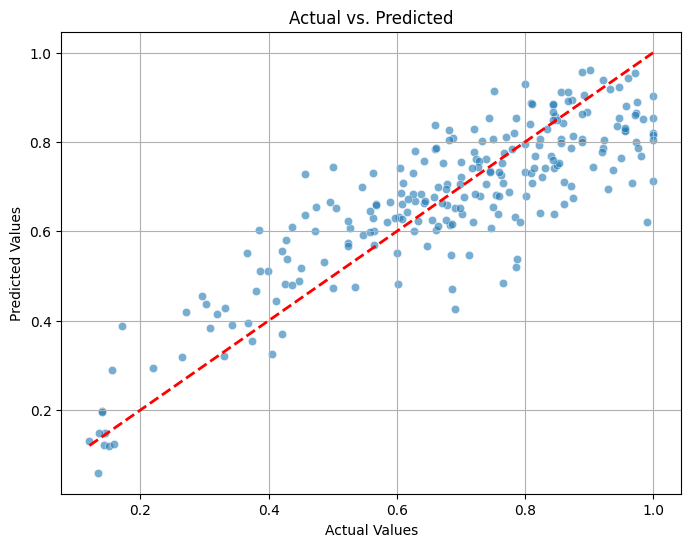

In [97]:
#Visualization of Actual vs Predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=results_df['Actual'], y=results_df['Predicted'], alpha=0.6)
plt.plot([results_df['Actual'].min(), results_df['Actual'].max()],
         [results_df['Actual'].min(), results_df['Actual'].max()],
         color='red', linestyle='--', linewidth=2)  # Diagonale Linie
plt.title('Actual vs. Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

---
**Analysis**

▸ Most points sit reasonably close to the red line, which means the model is able to reproduce the real attendance levels fairly well.

▸ The fit is strongest in the normal range of matches (roughly 20%–80% attendance). That’s also where most of the data lives, so the model had more examples to learn from.

**Where does it struggle?**

▸ The model tends to **overpredict very low-attendance games** (below ~0.25). That makes sense as there aren’t many truly empty stadium cases in the dataset, so the model defaults toward “average”.

▸ It also **underpredicts near sell-outs** (above ~0.85). Again expected: high-capacity, fully packed matches (derbies, European cups) are rare, so the model plays it safe and pulls those predictions downward.

▸ Result: the model is biased toward the middle — it’s most accurate where the dataset is densest, and less accurate on extremes.


**Main Takeaways**

▸ Overall, the model captures the general shape of attendance well, but it smooths out the peaks and dips.

**Residual analysis**: The systematic over/underprediction at extremes is a hallmark of regression to the mean. With only ~6% of matches below 25% attendance and ~11% above 90%, the model has limited examples to learn extreme behavior. This is a data limitation, not a model failure — adding more seasons would help capture rare events like boycotts, weather emergencies, or championship deciders.

In [98]:
df['PercentageAttendance'].describe()
df['PercentageAttendance'].value_counts(bins=10, normalize=True)

(0.633, 0.724]     0.170551
(0.541, 0.633]     0.155720
(0.724, 0.816]     0.151483
(0.816, 0.908]     0.150424
(0.908, 1.0]       0.112288
(0.449, 0.541]     0.073093
(0.0796, 0.173]    0.062500
(0.357, 0.449]     0.054025
(0.265, 0.357]     0.051907
(0.173, 0.265]     0.018008
Name: proportion, dtype: float64

**Final Model Analysis & Key Limitations**

▸ **The dataset is narrow, not deep.**  
We have 822 matches from a single league across ~3 seasons. The model learns "average Jupiler Pro League behaviour" rather than edge cases or club-specific dynamics.

▸ **Weather does not improve predictions — and slightly hurts tree models.**  
Adding weather features provides no benefit to linear models and marginally *decreases* XGBoost performance (0.740 → 0.733 R²). This happens because uninformative features dilute the model's focus on strong predictors. SHAP confirms: all weather features have importance scores near zero.

▸ **Why weather ends up irrelevant here:**  
- **Ticket timing**: Most tickets are sold days/weeks before the match, before accurate weather forecasts exist  
- **Season tickets**: A significant portion of attendance is season ticket holders who attend regardless of conditions  
- **Weather variance**: Belgium has mild, relatively consistent weather — there are almost no extreme heat, blizzard, or storm events in the dataset  
- **Sample imbalance**: Only ~20% of matches had "bad" weather, and very few had severe conditions

▸ **Attendance is driven by structural + team quality factors.**  
Max Capacity alone accounts for ~40% of SHAP importance, followed by team rankings and club-specific effects. This makes sense: attendance is primarily a function of *who* is playing, not *what the weather is*.

▸ **The model struggles at the extremes.**  
It overpredicts very low-attendance games and underpredicts near sell-outs. This is regression to the mean caused by data imbalance — only 6% of matches had <25% attendance.

▸ **Linear models perform nearly as well as tree models.**  
Linear Regression (R² = 0.73) nearly matches XGBoost (R² = 0.74), suggesting the relationships are mostly linear. The non-linear gains from gradient boosting are marginal for this problem.

▸ **Missing variables explain most of what's left unexplained (~26% variance).**  
Factors not in the data but known to drive attendance:
- Season ticket holder base per club
- Ticket pricing and promotional campaigns
- TV broadcast schedule (prime-time matches may have lower attendance)
- European competition fatigue (midweek CL/EL matches affect weekend crowds)
- Local events and transport disruptions
- Historical rivalry intensity beyond the simple "Derby" flag

---

### What This Means for Stakeholders

The model is **reliable for predicting typical Pro League matches** (~50–85% attendance range) with ~11% RMSE. However:
- It won't accurately forecast **unusual games** — packed derbies, boycotted matches, or extreme weather fixtures
- It learns the "center of gravity" of Belgian football crowds, not the emotional spikes
- **Weather data can be excluded** from production deployments without loss of accuracy

---

### Where to Go From Here

▸ **Add more seasons** → Reduces extreme-case imbalance and captures long-term trends  
▸ **Add more leagues** → Tests generalization beyond Belgian football  
▸ **Add fanbase variables** → Season ticket counts, social media following, historical attendance  
▸ **Add ticket pricing** → Captures demand elasticity and promotional effects  
▸ **Build club-specific models** → A hierarchical model with club-level random effects may capture idiosyncratic patterns  
▸ **Time-series approach** → Capture momentum effects (winning streaks boost attendance)